# Example 6 - Multi-objective optimization for plug flow reactor

In this example, we will demonstrate how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front. We will use the PFR model from [example 5](05_PFR_yield.ipynb). Two output variables will be generated from the model: yield (`y1`) and selectivity (`y2`). Unfortunately, these two variables cannot be maximized simultaneously. An increase in yield would lead to a decrease in selectivity, and vice versa. Multi-objective optimization derives a set of solutions that define the tradeoff between competing objectives. The boundary defined by the entire feasible solution set is called the Pareto front. 

In `nextorch`, we implement weighted sum method to construct the Pareto front. It is commonly used for convex problems. A set of objectives are scalarized to a single objective by adding each objective pre-multiplied by a user-supplied weight. The weight of an objective is chosen in proportion to its relative importance. The optimization is simply performed with respected to the scalarized objective. By varying the weight combinations, we can construct the whole Pareto front. 

For this example, the scalarized objective can be written as,
$$ y = w_1 y_1 + w_2 y_2 $$
where the weights $ w_1, w_2 \in [0, 1] $ and $w_1 + w_2 = 1 $.

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

In [1]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [2]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield and selectivity
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi = Reactor(**Conditions)        
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
        
    return Y_real # yield, selectivity


# Objective function
objective_func = PFR


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# two outputs
Y_name_with_unit = ['Yield %', 'Selectivity %']

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = len(Y_name_with_unit) # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


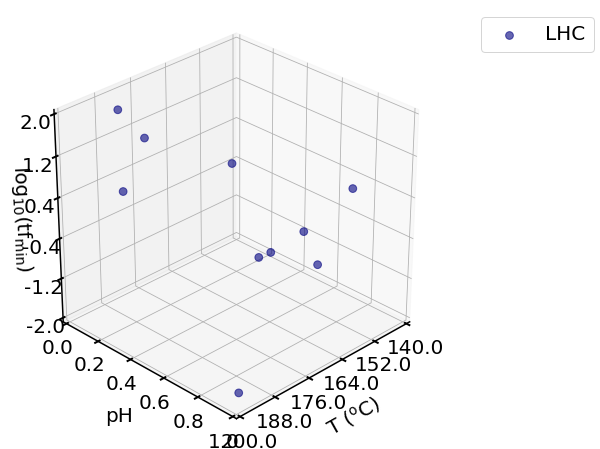

In [3]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(X_init_lhc, 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = 'LHC')

## 4. Initialize an `Experiment` object 

In this example, we use an `MOOExperiment` object, a class designed for multi-objective optimization. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `MOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`:
- Name of the experiment, used for output folder name
- Input independent variables X: `X_init` or `X_init_real`
- List of X ranges: `X_ranges`
- Output dependent variables Y: `Y_init` or `Y_init_real`

Optional:
- `unit_flag`: `True` if the input X matrix is a unit scale, else `False`
- `objective_func`: Used for test plotting
- `maximize`: `True` if we look for maximum, else `False` for minimum

Additionally, `weights` is required for `MOOExperiment.set_optim_specs` function. It defines a list of weights for objective 1. The weights of objective 2 is 1 minus that of objective 1. Under the hood, each weight combination correponds to a single `Experiment` object, each with a different scalarized objective. 

Some progress status will be printed out while initializing all single `Experiment` objects.

In [4]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.MOOExperiment('PFR_yield_MOO')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name_with_unit,
                   Y_names = Y_name_with_unit,
                   unit_flag = True)

# Set the optimization specifications 
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 10 # number of single Experiments

# Set a weight vector for objective 1: [0, 0.1, ... 0.9]
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True, 
                        weights = weights_obj_1)
end_time = time.time()
print('Initializing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Initializing 10 experiments
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 10.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 20.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 30.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 40.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 50.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 60.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288864135742
Initializing experiments 70.00 % 
Iter 10/100: 5.538654327392578
Iter 20/100: 5.134474277496338
Iter 30/100: 4.929288

## 5. Run trials 

At each weight combinations, we perform an optimization task for the scalarized objective (a single `Experiment`). `MOOExperiment.run_exp_auto` run these tasks automatically by using the default choice of acqucision function, Expected improvement (EI). It takes in the number of trials required for each `Experiment`. The number of trials needs to be large enough which allows Bayesian Optimization algorithm to converge to the optimum. In this example, the evalution would be slow since the total number of calls for the objective function is `n_trails` * `n_exp` (=300). 

Some progress status will be printed out during the training.

In [5]:
# Set the number of iterations for each experiments
n_trials_lhc = 30 
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print('Optimizing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Running 10 experiments
Iter 10/100: 4.183126926422119
Iter 20/100: 3.9436559677124023
Iter 30/100: 3.821441173553467
Iter 40/100: 3.787433624267578
Iter 50/100: 3.7611100673675537
Iter 60/100: 3.7408950328826904
Iter 70/100: 3.726273536682129
Iter 80/100: 3.7125473022460938
Iter 90/100: 3.698540687561035
Iter 100/100: 3.6746740341186523
Iter 10/100: 3.457542896270752
Iter 20/100: 3.429641008377075
Iter 30/100: 3.409529209136963
Iter 40/100: 3.3941402435302734
Iter 50/100: 3.3818953037261963
Iter 60/100: 3.371882438659668
Iter 70/100: 3.3635525703430176
Iter 80/100: 3.35646390914917
Iter 90/100: 3.350341320037842
Iter 100/100: 3.3449859619140625
Iter 10/100: 3.298649311065674
Iter 20/100: 3.2675607204437256
Iter 30/100: 3.259054660797119
Iter 40/100: 3.2535057067871094
Iter 50/100: 3.2482619285583496
Iter 60/100: 3.2442731857299805
Iter 70/100: 3.240795850753784
Iter 80/100: 3.23775577545166
Iter 90/100: 3.235085964202881
Iter 100/100: 3.2327070236206055
Iter 10/100: 2.9958908557891846


Iter 70/100: 3.7087786197662354
Iter 80/100: 3.67897891998291
Iter 10/100: 3.1503453254699707
Iter 20/100: 3.1271181106567383
Iter 30/100: 3.1107640266418457
Iter 40/100: 3.0992932319641113
Iter 50/100: 3.0908403396606445
Iter 60/100: 3.0843300819396973
Iter 70/100: 3.0791563987731934
Iter 80/100: 3.0749568939208984
Iter 90/100: 3.0714638233184814
Iter 100/100: 3.068513870239258
Iter 10/100: 1.7657266855239868
Iter 20/100: 1.5588468313217163
Iter 30/100: 0.8863846063613892
Iter 40/100: 0.717034101486206
Iter 50/100: 0.593408465385437
Iter 60/100: 0.4984775185585022
Iter 70/100: 0.4492315948009491
Iter 80/100: 0.43398624658584595
Iter 90/100: 0.427379846572876
Iter 100/100: 0.42012178897857666
Iter 10/100: 0.40500131249427795
Iter 20/100: 0.38105469942092896
Iter 30/100: 0.36334308981895447
Iter 40/100: 0.3553086519241333
Iter 50/100: 0.3533667027950287
Running experiments 80.00 % 
Iter 10/100: 4.138969898223877
Iter 20/100: 3.8663010597229004
Iter 30/100: 3.7699456214904785
Iter 40/100

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `MOOExperiment` object by using `MOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The region below $ y=x $ is infeasible for the PFR model and we have no Pareto points fall below the line, incidating the method is validate. 

$\rm w_1$  $\rm w_2$  T ($\rm ^{o}C $)    pH  $\rm log_{10}(tf_{min})$  \
0       0.00       1.00            140.00  1.00                     -2.00   
1       0.11       0.89            140.00  1.00                     -2.00   
2       0.22       0.78            200.00  1.00                     -1.25   
3       0.33       0.67            200.00  0.00                     -2.00   
4       0.44       0.56            200.00  1.00                     -0.98   
5       0.56       0.44            200.00  1.00                     -0.98   
6       0.67       0.33            200.00  0.02                     -1.94   
7       0.78       0.22            186.61  0.64                     -0.89   
8       0.89       0.11            200.00  1.00                     -0.87   
9       1.00       0.00            200.00  0.97                     -0.88   

   Yield %  Selectivity %  
0     0.10          65.35  
1     0.10          65.35  
2    38.92          59.37  
3    48.18          56.54  
4    48.68          56.19  
5    48.63          56.23  
6    49.14          55.77  
7    48.30          54.62  
8    50.06          54.05  
9    50.10          53.66

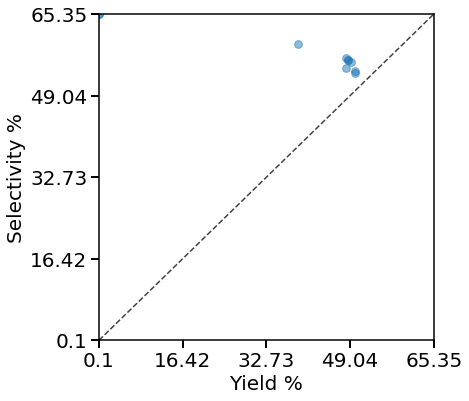

In [8]:
from nextorch import io
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = [r'$\rm w_1$', r'$\rm w_2$'] 

# Parse the optimum into a table
data_opt = io.np_to_dataframe([weights_obj_1, weights_obj_2, np.array(X_real_opts), Y_real_opts], weight_names + var_names)
display(data_opt.round(decimals=2))

# Make the pareto plots 
plotting.pareto_front_exp(Exp_lhc, fill = False)

## References:
Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model